# COVID-19 Daily Data Collection - An ETL process for Pandemic Data

### Eric Tsibertzopoulos, Ken Brooks - Oasys Inc.    
#### November 2020

**Rational**: Leverage R processing on the Spark Cluster with support for Detla-Lake transactional data storage 

Technical capability demontrated:
* Web Scraping and Data Refinery with R
* R Data Visualization
* Data WRITE/READ to/from Delta-Lake
* Spark Cluster based data partitioning
* Spark data aggregation

Spark Cluster
![cluster](./data/cluster.png)

Data Science Stack:
* Jupyter 6.0.6
* R 3.6.0  (dplyr, sparklyr, ggplot2, rvest)
* Apache Spark 2.4.5
* Delta-Lake 0.4.0
* Windows 10

In [34]:
# Load necessary R data libraries
library(sparklyr)  # Interface to Apache Spark
library(dplyr)     # Data Refinery/wrangling
library(ggplot2)   # Data Visualization
library(rvest)     # Web Scraping

In [35]:
# Set up spark configuration to load the JAR file containing the Delta-Lake API (dependency for SparklyR)
configuration <- spark_config()
configuration$`sparklyr.jars.default` <- c("C://spark-2.4.5//jars//delta-core_2.11-0.4.0.jar")

In [36]:
# Connect to Spark Cluster with custom configuration
sc<- spark_connect(master="spark://10.146.96.109:7077", version="2.4.5", app_name = "COVID-19_ETL", config=configuration)

[Source](https://www.worldometers.info/coronavirus/) Data for Covid-19

In [37]:
# Covid Data Source online:
url<-"https://www.worldometers.info/coronavirus/"

#Scrape Web data from table with ID: main_table_countries_today
data <- url %>%
  read_html() %>%
  html_nodes("#main_table_countries_today") %>%
  html_table()

# Clean up some not needed rows and columns
df<-as.data.frame(data[1], stringsAsFactors = F)
df<-df[-(1:8),]
df<-subset(df, df$Country.Other != "Total:")
df<-df[,-c(1,17,18,19)]
colnames(df)<-c("Country","TotalCases","NewCases","TotalDeaths","NewDeaths","TotalRecovered","NewRecovered","ActiveCases","Critical","TotalCases1Mpop", "Deaths1Mpop","TotalTests","Tests1Mpop","Population","Continent")

# Transform key columns to numerics
df$TotalCases<-as.numeric(gsub(",", "", df$TotalCases))
df$NewCases<-as.numeric(gsub(",", "", df$NewCases))
df$TotalDeaths<-as.numeric(gsub(",", "", df$TotalDeaths))
df$NewDeaths<-as.numeric(gsub(",", "", df$NewDeaths))
df$TotalRecovered<-as.numeric(gsub(",", "", df$TotalRecovered))
df$NewRecovered<-as.numeric(gsub(",", "", df$NewRecovered))
df$ActiveCases<-as.numeric(gsub(",", "", df$ActiveCases))
df$Critical<-as.numeric(gsub(",", "", df$Critical))
df$TotalCases1Mpop<-as.numeric(gsub(",", "", df$TotalCases1Mpop))
df$Deaths1Mpop<-as.numeric(gsub(",", "", df$Deaths1Mpop))
df$TotalTests<-as.numeric(gsub(",", "", df$TotalTests))
df$Tests1Mpop<-as.numeric(gsub(",", "", df$Tests1Mpop))
df$Population<-as.numeric(gsub(",", "", df$Population))
# Mutation: Add a new column for the ETL data-collection data
df$date<-Sys.Date()

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"
Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"
Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"


In [48]:
# Preview the R in-memory Data Frame
head(df[,1:9], 10)

,Country,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,Critical
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,USA,10559184,NA,245799,NA,6601331,NA,3712054,19374
10,India,8635754,NA,127615,NA,8011844,NA,496295,8944
11,Brazil,5701283,NA,162842,NA,5064344,NA,474097,8318
12,France,1829659,NA,42207,NA,131920,NA,1655532,4750
13,Russia,1817109,NA,31161,NA,1350741,NA,435207,2300
14,Spain,1443997,NA,39756,NA,NA,NA,NA,3064
15,Argentina,1262476,NA,34183,NA,1081897,NA,146396,4494
16,UK,1233775,NA,49770,NA,NA,NA,NA,1268
17,Colombia,1156675,NA,33148,NA,1059237,NA,64290,2376


Using Country as id variables

Warning message:
"Removed 3 rows containing missing values (position_stack)."


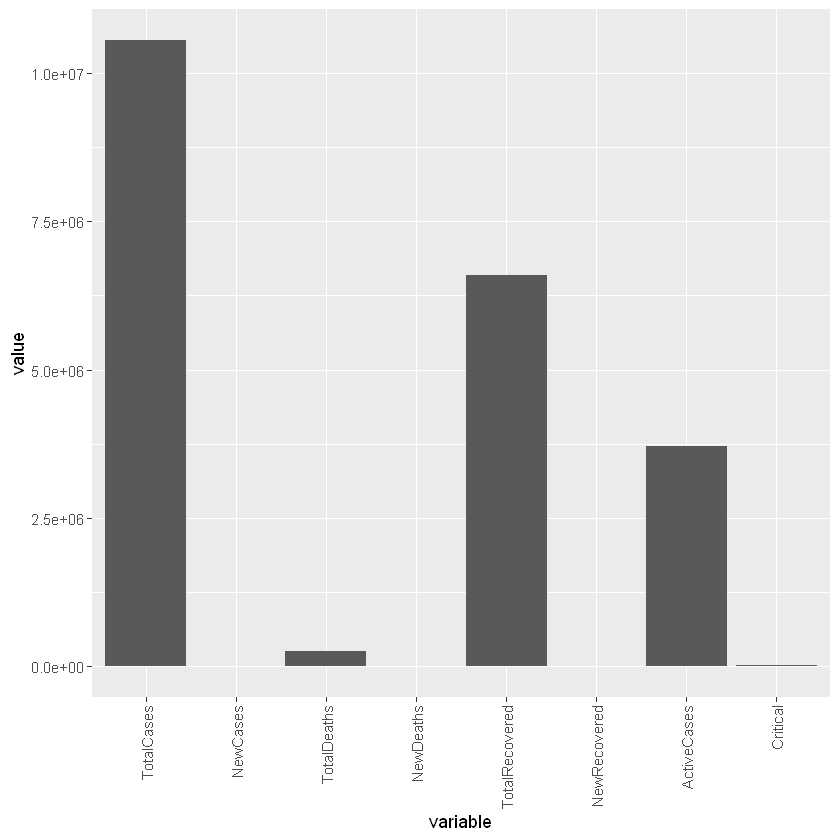

In [39]:
# Do a basic Data exploration for USA
reshape2::melt(subset(df, df$Country=="USA")[,1:9]) %>% ggplot(aes(x=variable, y=value))+
    geom_bar(stat="identity") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [40]:
# Copy the R in-memory data frame to Spark's memory, name it covid19
covid_df<-copy_to(sc, df, "covid19", overwrite=T)

In [41]:
# Write the Spark data frame to a Delta-Lake location in Delta format with Append mode, 
# and partition the data storage by Country
spark_write_delta(covid_df,"c://delta//covid19", mode ="append", options = list(), partition_by ="Country" )

In [42]:
# Read data from the Delta-Lake into Saprk's memory, overite any previous memory resident data frame "covid19"
df2<-spark_read_delta(sc, "c://delta//covid19", "covid19", overwrite=T)

In [43]:
# Explore the Spark data frame
glimpse(df2)

Rows: ??
Columns: 16
Database: spark_connection
$ Country         <chr> "Mexico", "Mexico", "Bolivia", "Bolivia", "Belize",...
$ TotalCases      <dbl> 978531, 978531, 142664, 142664, 4414, 507475, 34818...
$ NewCases        <dbl> 5746, 5746, 103, 103, 184, 4293, 1708, 1708, 146, 1...
$ TotalDeaths     <dbl> 95842, 95842, 8808, 8808, 73, 13561, 7021, 7021, 48...
$ NewDeaths       <dbl> 617, 617, 6, 6, 2, 345, 21, 21, 2, 2, NaN, NaN, NaN...
$ TotalRecovered  <dbl> 725846, 725846, 115199, 115199, 2440, 30504, 320065...
$ NewRecovered    <dbl> 4770, 4770, 318, 318, 54, 708, 634, 634, 106, 106, ...
$ ActiveCases     <dbl> 156843, 156843, 18657, 18657, 1901, 463410, 21098, ...
$ Critical        <dbl> 2615, 2615, 71, 71, 3, 1474, 1109, 1109, 49, 49, Na...
$ TotalCases1Mpop <dbl> 7561, 7561, 12162, 12162, 11029, 43718, 1565, 1565,...
$ Deaths1Mpop     <dbl> 741, 741, 751, 751, 182, 1168, 32, 32, 9, 9, 5, 5, ...
$ TotalTests      <dbl> 2537046, 2537046, 341225, 341225, 25690, 5321108, 4...
$ Te

In [44]:
# Aggregate all NewCases in the data frame and collect the metric in R memory
df2 %>% summarise(total_NewCases = sum(NewCases,na.rm=T)) %>% collect()

total_NewCases
<dbl>
21065


In [45]:
# Aggregate all NewCases for USA in the data frame and collect the metric in R memory
df2 %>% filter(Country=="USA") %>% summarise(total_NewCases = sum(NewCases,na.rm=T)) %>% collect()

total_NewCases
<dbl>
NaN


In [33]:
# Disconnect from the cluster
spark_disconnect(sc)